# Dependencies

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
import yaml
import os
import sys

sys.path.append(os.path.join(os.getcwd(), 'src'))
import pickle
import joblib
import src.utils as utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
import yaml
import pickle
import joblib
import os
import src.utils as utils
import importlib
importlib.reload(utils)

## load configuration file
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
root_path = os.getcwd()

In [4]:
## load constant variables
TARGET_COL = config['data_source']['target_col']
TEST_SZ = config['data_source']['test_size']
SEED_ST = config['data_source']['random_state']
NUM_COLS = config['data_source']['num_cols']
CAT_COLS = config['data_source']['cat_cols']
CORR_COLS = config['data_source']['corr_cols']

## data
X_TRAIN_PATH = config['processed_files']['X_train']
X_TEST_PATH = config['processed_files']['X_test']
X_VALID_PATH = config['processed_files']['X_valid']
y_TRAIN_PATH = config['processed_files']['y_train']
y_TEST_PATH = config['processed_files']['y_test']
y_VALID_PATH = config['processed_files']['y_valid']
X_TRAIN_ROS_PATH = config['ROS_file']['X_train']
y_TRAIN_ROS_PATH = config['ROS_file']['y_train']

## Desirialize Pickle Data
var_name = ["X_train_prep", "X_test_prep", "X_valid_prep", "y_train_prep", "y_test_prep", "y_valid_prep", "X_train_ros", "y_train_ros"]
stock_list = [X_TRAIN_PATH, X_TEST_PATH, X_VALID_PATH, y_TRAIN_PATH, y_TEST_PATH, y_VALID_PATH, X_TRAIN_ROS_PATH, y_TRAIN_ROS_PATH]
for var_name, path in zip(var_name, stock_list):
    globals()[var_name] = utils.deserialize_data(path)

In [5]:
X_train_ros.isna().sum()

person_age                       0
person_income                    0
person_emp_length                0
loan_amnt                        0
loan_int_rate                    0
loan_percent_income              0
cb_person_cred_hist_length       0
home_ownership_MORTGAGE          0
home_ownership_OTHER             0
home_ownership_OWN               0
home_ownership_RENT              0
loan_intent_DEBTCONSOLIDATION    0
loan_intent_EDUCATION            0
loan_intent_HOMEIMPROVEMENT      0
loan_intent_MEDICAL              0
loan_intent_PERSONAL             0
loan_intent_VENTURE              0
loan_grade_A                     0
loan_grade_B                     0
loan_grade_C                     0
loan_grade_D                     0
loan_grade_E                     0
loan_grade_F                     0
loan_grade_G                     0
default_onfile_N                 0
default_onfile_Y                 0
dtype: int64

In [6]:
y_train_ros.isna().sum()

np.int64(0)

In [6]:
X_train_ros

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,default_onfile_N,default_onfile_Y
0,45,37500,1.0,5000,11.49,0.13,16,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,25,50000,5.0,12000,7.88,0.24,2,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,24,78000,4.0,30000,10.99,0.38,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,31,78504,2.0,10000,11.41,0.13,7,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,26,14000,2.0,4000,10.99,0.29,3,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40555,22,53000,5.0,25000,13.43,0.47,4,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
40556,25,57504,2.0,16500,9.32,0.29,3,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
40557,28,60675,6.0,14000,15.62,0.23,10,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
40558,33,32400,8.0,11000,6.99,0.34,10,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [21]:
## import metrics dependencies

from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix, make_scorer, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from copy import deepcopy
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

Based on the previous exercises, there the XG-Boost algortihm performs really well with this data. This exercise will explore the comparison of the best algorithm to other simpler model such as Logistic Regression and Tree-model. In this instance we will perform hyperparameter search for each algorithm with cross validated grid search.

#### y_train to Classifier

In [9]:
y_train_array = np.array(y_train_ros.copy(), dtype='int32')

#### Odds of Guessing

In [10]:
proba_Default = 0.5 ; proba_nonDefault = 0.5
proportion_nonDefault = y_train_ros.value_counts(normalize=True)[0]
proportion_Default = y_train_ros.value_counts(normalize=True)[1]

In [11]:
### odds default
odds_default = proportion_Default * proba_Default
print(f"Odds for default prediction: {round(odds_default,2)}")

Odds for default prediction: 0.25


In [12]:
### odds default
odds_nonDefault = proportion_nonDefault * proba_nonDefault
print(f"Odds for default prediction: {round(odds_nonDefault,2)}")

Odds for default prediction: 0.25


## XG Boost

In [12]:
def gridsearch_train(classifier, hyperparams: dict, CPU_unit, train_input:pd.DataFrame, train_output:pd.DataFrame):
    estimator = GridSearchCV(
        estimator=classifier, param_grid=hyperparams, scoring='roc_auc', verbose=3, n_jobs=CPU_unit, cv=5, error_score='raise')
    estimator.fit(train_input, train_output)

    optimal_params = estimator.best_params_
    print(f"\nBest params from grid search: {optimal_params}")
    print(f"With best params, roc_auc score is: {round(estimator.best_score_,2)}")

    return optimal_params

def eval_classification(y_true, y_pred, classifier):
    y_true_arr = np.array(y_true.copy(), dtype='int32')
    y_pred_arr = np.array(y_pred.copy(), dtype='int32')

    disp =ConfusionMatrixDisplay(confusion_matrix(y_true_arr, y_pred_arr), display_labels=classifier.classes_)
    disp.plot(cmap='binary', colorbar=True, values_format='d')
    plt.grid(False)
    plt.title("Confusion Matrix of Classes")
    plt.show()

    print(f"\n{classification_report(y_true_arr, y_pred_arr)}")

In [13]:
####'#### XGBoost
clf_xgb = XGBClassifier(objective="binary:logistic", subsample=0.9, colsample_bytree=0.5, seed=SEED_ST)

xgb_params_1 = {
    "max_depth": [3, 4, 5],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1.0, 10.0],
    "scale_pos_weight": [1, 3, 5]
}
###################################  Results ####################################
# best params from grid search: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3,
# 'reg_lambda': 0, 'scale_pos_weight': 1}

# more exploration should be done in learning rate and max depth
#################################################################################


xgb_params_2 = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 1, 10],
    "gamma": [0],
    "reg_lambda": [0],
    "scale_pos_weight": [1]
}

###################################  Results ####################################
# best params from grid search: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 1}

# result from the second hyperparameter show a stable learning rate. However we need to perform more search for max_depth
#################################################################################



xgb_params_3 = {
    "max_depth": [9, 12, 15],
    "learning_rate": [1],
    "gamma": [0],
    "reg_lambda": [0],
    "scale_pos_weight": [1]
}

###################################  Results ####################################
# best params from grid search: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 1}

# now all of our hyperparameters are stable. we can extract the result in a variable called xgb_opt_params to be used for our model training. However upon more testing its shown that the parameters overfits the training data and do not generalize to the validation data
#################################################################################


xgb_opt_params = gridsearch_train(clf_xgb, hyperparams=xgb_params_1, CPU_unit=10, train_input=X_train_ros, train_output=y_train_array)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits

Best params from grid search: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 0, 'scale_pos_weight': 3}
With best params, roc_auc score is: 0.95


In [14]:
xgb_opt_params

{'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 5,
 'reg_lambda': 0,
 'scale_pos_weight': 3}

In [15]:
best_xgb = XGBClassifier(**xgb_opt_params)
best_xgb.fit(X_train_ros, y_train_ros)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

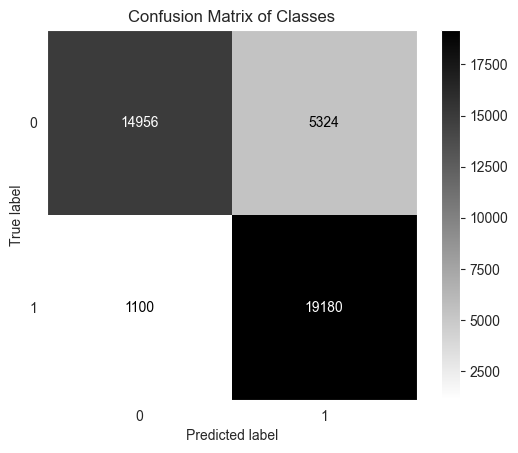


              precision    recall  f1-score   support

           0       0.93      0.74      0.82     20280
           1       0.78      0.95      0.86     20280

    accuracy                           0.84     40560
   macro avg       0.86      0.84      0.84     40560
weighted avg       0.86      0.84      0.84     40560



In [16]:
y_pred_xgb = best_xgb.predict(X_train_ros)

eval_classification(y_train_array, y_pred_xgb, best_xgb)

## Logistic Regression

In [17]:
######## Logistic Regression
clf_lgreg = LogisticRegression(random_state=SEED_ST)

# lgreg_params_1 = {
#     "penalty"           : ['l2', 'l1'],
#     "C"                 : [0.001, 0.01, 0.1],
#     "fit_intercept"     : [True, False],
#     "solver"            : ['liblinear', 'saga'],
#     "max_iter"          : [100, 250, 500],
# }

###################################  Results ####################################
# Best params from grid search: {'C': 0.1, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
# With best params, f1 score is: 0.7939004526536887

# we need to explore hyperparams of max_iter and C.
#################################################################################


# lgreg_params_2 = {
#     "penalty"           : ['l1'],
#     "C"                 : [0.1, 1, 10],
#     "fit_intercept"     : [True],
#     "solver"            : ['liblinear'],
#     "max_iter"          : [10, 50, 100],
# }

###################################  Results ####################################
# Best params from grid search: {'C': 10, 'fit_intercept': True, 'max_iter': 10, 'penalty': 'l1', 'solver': 'liblinear'}
# With best params, f1 score is: 0.7947924346403775

# number of C is still not stable we can try more combination. there are warning to keep iteration higher than 10. therefore we will set the value to 100 as same as defualt value in sklearn.
#################################################################################

lgreg_params_3 = {
    "penalty"           : ['l1'],
    "C"                 : [10, 25, 50],
    "fit_intercept"     : [True],
    "solver"            : ['liblinear'],
    "max_iter"          : [100],
}

lgreg_opt_params = gridsearch_train(clf_lgreg, hyperparams=lgreg_params_3, CPU_unit=10, train_input=X_train_ros, train_output=y_train_array)

Fitting 5 folds for each of 3 candidates, totalling 15 fits

Best params from grid search: {'C': 25, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
With best params, roc_auc score is: 0.87


In [18]:
lgreg_opt_params

{'C': 25,
 'fit_intercept': True,
 'max_iter': 100,
 'penalty': 'l1',
 'solver': 'liblinear'}

In [19]:
best_lgreg = LogisticRegression(**lgreg_opt_params)
best_lgreg.fit(X_train_ros, y_train_array)

LogisticRegression(C=25, penalty='l1', solver='liblinear')

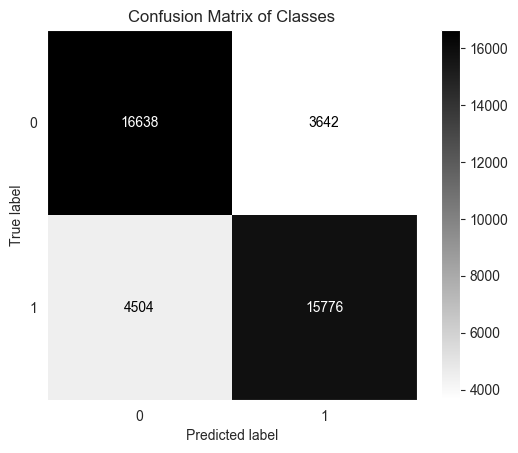


              precision    recall  f1-score   support

           0       0.79      0.82      0.80     20280
           1       0.81      0.78      0.79     20280

    accuracy                           0.80     40560
   macro avg       0.80      0.80      0.80     40560
weighted avg       0.80      0.80      0.80     40560



In [20]:
y_pred_lgreg = best_lgreg.predict(X_train_ros)

eval_classification(y_train_array, y_pred_lgreg, best_lgreg)

## Decision Tree Classifier

In [27]:
######## Random Forest
tree_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10, 20],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}

clf_dtc = DecisionTreeClassifier()

In [28]:
tree_opt_params = gridsearch_train(clf_dtc, hyperparams=tree_grid, CPU_unit=10, train_input=X_train_ros, train_output=y_train_array)

Fitting 5 folds for each of 96 candidates, totalling 480 fits

Best params from grid search: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_split': 20}
With best params, roc_auc score is: 0.97


In [30]:
best_tree = DecisionTreeClassifier(**tree_opt_params)
best_tree.fit(X_train_ros, y_train_array)

DecisionTreeClassifier(criterion='entropy', min_samples_split=20)

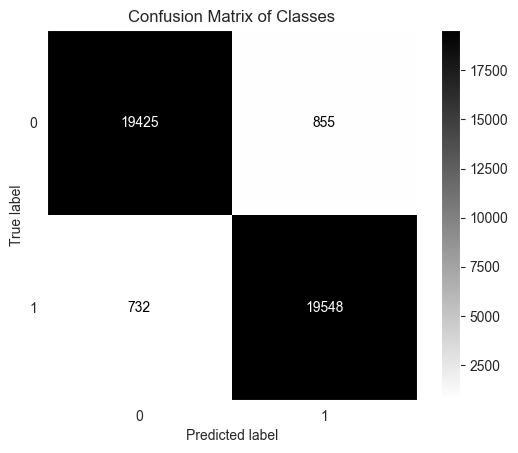


              precision    recall  f1-score   support

           0       0.96      0.96      0.96     20280
           1       0.96      0.96      0.96     20280

    accuracy                           0.96     40560
   macro avg       0.96      0.96      0.96     40560
weighted avg       0.96      0.96      0.96     40560



In [31]:
y_pred_tree = best_tree.predict(X_train_ros)

eval_classification(y_train_array, y_pred_tree, best_tree)

## Tuning and Evaluation

In [32]:
X_valid = X_valid_prep ; y_valid = np.array(y_valid_prep.copy(), dtype='int32')

In [40]:
def evaluation_valid(input: pd.DataFrame, output:np.array , classifier):

    ## Create instance of prediction probability
    testing_proba = classifier.predict_proba(input)[:,1]

    ## create empty metric list to store metrics result for each prediction instance.
    metrics_df = pd.DataFrame()

    ## populate metrics object with incrementing threshold from 0 to 100
    for threshold in np.linspace(0,1,100):
        predictions = (testing_proba > threshold).astype(int)
        metrics = classification_report(output, predictions, output_dict=True)

        # Extract class-wise results
        for label, metric in metrics.items():

            # Check if the current label is '1'
            if label == '1':
                temp_df = pd.DataFrame({
                                    'model': classifier.__class__.__name__,
                                    'threshold': threshold,
                                    'class': label,
                                    'precision': metric['precision'],
                                    'recall': metric['recall'],
                                    'f1_score': metric['f1-score']
                                   }, index=[0])

                # Append each metrics as a new row in the DataFrame
                metrics_df = pd.concat([metrics_df, temp_df], ignore_index=True)

    metric_list = [metrics_df['precision'], metrics_df['recall'], metrics_df['f1_score']]

    ## plot out metrics
    list_name = ['precision', 'recall', 'f1_score']
    for i, list in enumerate(metric_list):
        sns.lineplot(data=list, label=list_name[i])
    plt.title("Decision Boundary Classifier")
    plt.show()

E:\01_Programming\Py\Aditya_MLPROCESS\Aditya_venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\01_Programming\Py\Aditya_MLPROCESS\Aditya_venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\01_Programming\Py\Aditya_MLPROCESS\Aditya_venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

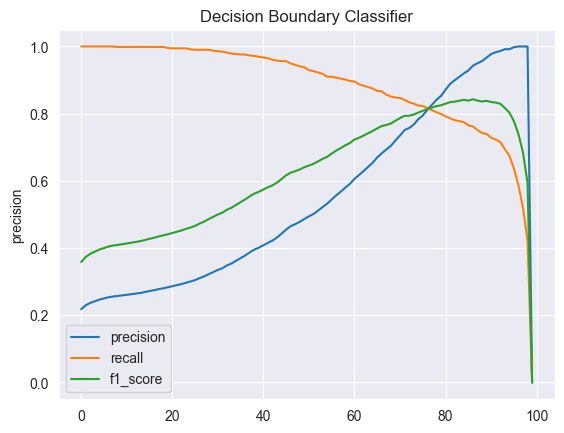

In [41]:
evaluation_valid(X_valid, y_valid, best_xgb)

E:\01_Programming\Py\Aditya_MLPROCESS\Aditya_venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\01_Programming\Py\Aditya_MLPROCESS\Aditya_venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\01_Programming\Py\Aditya_MLPROCESS\Aditya_venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

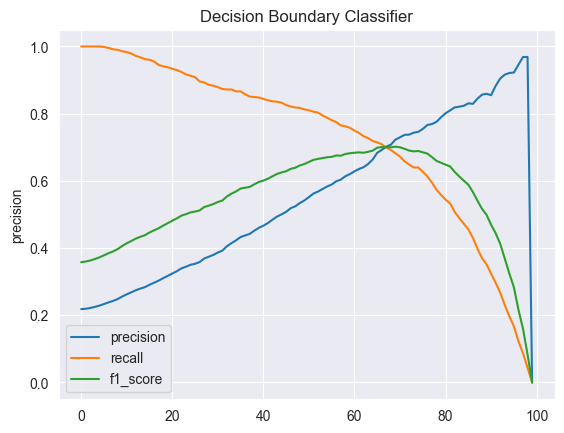

In [42]:
evaluation_valid(X_valid, y_valid, best_lgreg)

E:\01_Programming\Py\Aditya_MLPROCESS\Aditya_venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\01_Programming\Py\Aditya_MLPROCESS\Aditya_venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\01_Programming\Py\Aditya_MLPROCESS\Aditya_venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

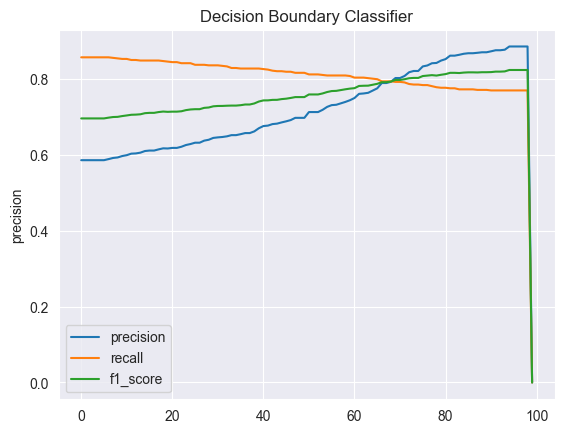

In [43]:
evaluation_valid(X_valid, y_valid, best_tree)

#### Testing with other ways - XGBoost & Logistic Regression

In [73]:
def evaluation_precision_recall(input, output, clf_xgb, clf2, clf3):
    yscores_xgb = cross_val_predict(clf_xgb, input, output, cv=5, method='predict_proba', n_jobs=10)[:, 1]
    yscores_clf2 = cross_val_predict(clf2, input, output, cv=5, method='predict_proba', n_jobs=10)[:, 1]
    yscores_clf3 = cross_val_predict(clf3, input, output, cv=5, method='predict_proba', n_jobs=10)[:, 1]
    list_clf = [clf_xgb, clf2, clf3]

    xgb_precision, xgb_recall, xgb_threshold = precision_recall_curve(output, yscores_xgb)
    clf2_precision, clf2_recall, clf2_threshold = precision_recall_curve(output, yscores_clf2)
    clf3_precision, clf3_recall, clf3_threshold = precision_recall_curve(output, yscores_clf3)

    all_clf = [(xgb_precision, xgb_recall, xgb_threshold), (clf2_precision, clf2_recall, clf2_threshold), (clf3_precision, clf3_recall, clf3_threshold)]

    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(6,12))

    for i, clf_metrics in enumerate(all_clf):
        clf_precision, clf_recall, clf_threshold = clf_metrics
        clf_name = list_clf[i].__class__.__name__

        ax[i].plot(clf_threshold, clf_precision[:-1], 'b--', label='precision')
        ax[i].plot(clf_threshold, clf_recall[:-1], 'r-', label='recall')
        ax[i].set_xlabel('Threshold')
        ax[i].set_title(f'Precision-Recall Curve {clf_name}')
        ax[i].legend(loc='lower center')

    plt.tight_layout()
    plt.show()

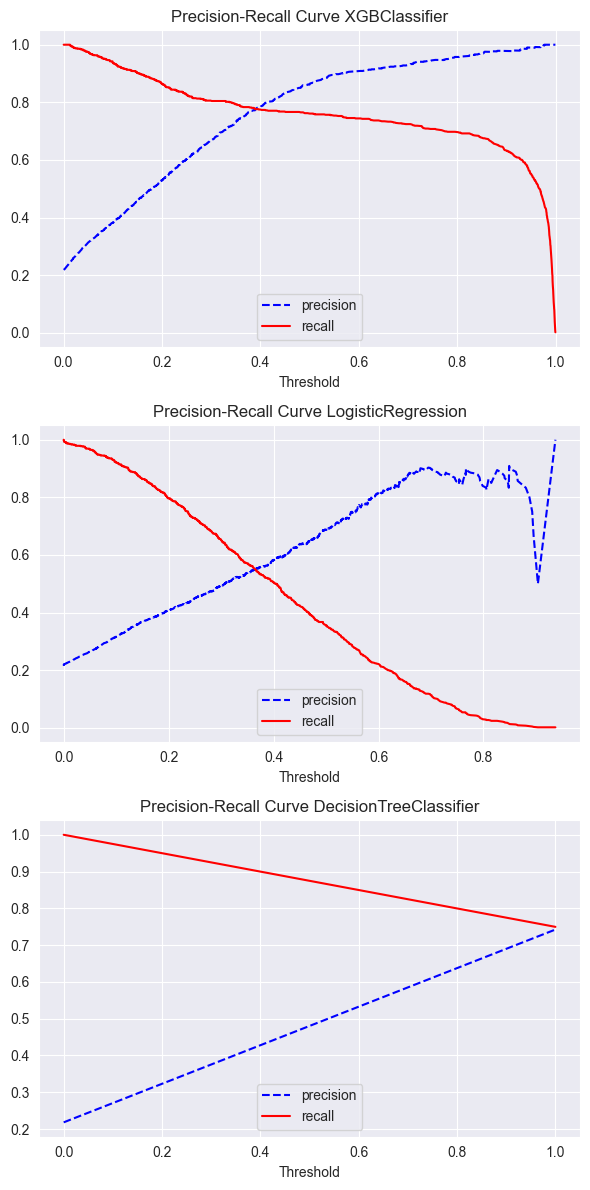

In [74]:
evaluation_precision_recall(X_valid, y_valid, best_xgb, clf_lgreg, clf_dtc)

In [83]:
def evaluation_ROC_AUC(input, output, clf_xgb, clf2, clf3):

    # predict using cross validation
    yscores_xgb = cross_val_predict(clf_xgb, input, output, cv=5, method='predict_proba', n_jobs=10)[:, 1]
    yscores_clf2 = cross_val_predict(clf2, input, output, cv=5, method='predict_proba', n_jobs=10)[:, 1]
    yscores_clf3 = cross_val_predict(clf3, input, output, cv=5, method='predict_proba', n_jobs=10)[:, 1]

    ## calculate auc for all classifier:
    xgb_fpr, xgb_tpr, threshold_xgb_roc = roc_curve(output, yscores_xgb); auc_xgb = auc(xgb_fpr, xgb_tpr)
    clf2_fpr, clf2_tpr, threshold_clf2_roc = roc_curve(output, yscores_clf2) ; auc_clf2 = auc(clf2_fpr, clf2_tpr)
    clf3_fpr, clf3_tpr, threshold_clf3_roc = roc_curve(output, yscores_clf3); auc_clf3 = auc(clf3_fpr, clf3_tpr)

    ## plot the True Positive and False positive Rate curve
    plt.plot(xgb_fpr,xgb_tpr, label='xgb (auc= %0.3f)' % auc_xgb)
    plt.plot(clf2_fpr,clf2_tpr, label='LogReg (auc= %0.3f)' % auc_clf2)
    plt.plot(clf3_fpr,clf3_tpr, label='Tree (auc= %0.3f)' % auc_clf3)

    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    auc_cluster = [auc_xgb, auc_clf2, auc_clf3]

    if max(auc_cluster) == auc_xgb:
        print(f"Best model to choose is the XG_Boost Model.")
        optimal_idx = np.argmin(np.sqrt(np.square(1-xgb_tpr) + np.square(xgb_fpr)))
        optimal_threshold = threshold_xgb_roc[optimal_idx]
        print(f"With the optimal threshold when considering granuality of ROC (FPR=0, TPR=1): %0.3f" % optimal_threshold)
        return optimal_threshold

    elif max(auc_cluster) == auc_clf2:
        print(f"Best model to choose is the Logistic Regression Model.")
        optimal_idx = np.argmin(np.sqrt(np.square(1-clf2_tpr) + np.square(clf2_fpr)))
        optimal_threshold = threshold_clf2_roc[optimal_idx]
        print(f"With the optimal threshold when considering granuality of ROC (FPR=0, TPR=1): %0.3f" % optimal_threshold)
        return optimal_threshold

    else:
        print(f"Best model to choose is the Logistic Regression Model.")
        optimal_idx = np.argmin(np.sqrt(np.square(1-clf3_tpr) + np.square(clf3_fpr)))
        optimal_threshold = threshold_clf3_roc[optimal_idx]
        print(f"With the optimal threshold when considering granuality of ROC (FPR=0, TPR=1): %0.3f" % optimal_threshold)
        return optimal_threshold


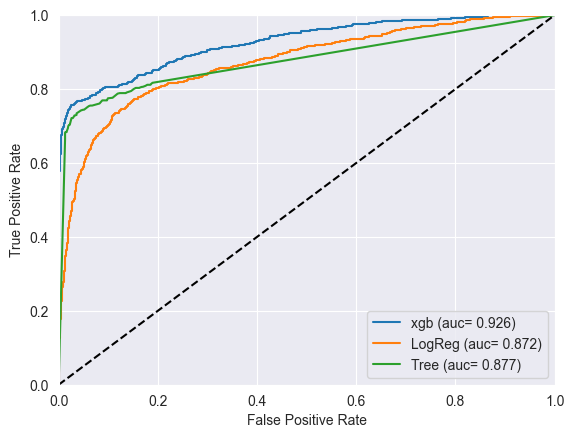

Best model to choose is the XG_Boost Model.
With the optimal threshold when considering granuality of ROC (FPR=0, TPR=1): 0.329


In [84]:
optimal_threshold = evaluation_ROC_AUC(X_valid, y_valid, best_xgb, best_lgreg, best_tree)

### testing with other metrics such as F1-Score

In [100]:
def evaluation_F1_scores(input, output, clf_xgb, clf2, clf3):
    ## predict the probabilities from each classifier
    yscores_xgb = clf_xgb.predict_proba(input)[:, 1]
    yscores_logreg = clf2.predict_proba(input)[:, 1]
    yscores_tree = clf3.predict_proba(input)[:, 1]

    classifiers = [(yscores_xgb, "XGB"), (yscores_logreg, "LogReg"), (yscores_tree, "Tree")]

    for clf_scores in classifiers:
        scores, clf_name = clf_scores
        precision, recall, thresholds = precision_recall_curve(output, scores)
        f1_scores = (2 * precision * recall ) / (precision + recall + 1e-10)

        # getting the optimal threshold
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]
        print(f"Classifier {clf_name} - Optimal threshold: {optimal_threshold}")

# Call the function
optimal_threshold_value = evaluation_F1_scores(X_valid, y_valid, best_xgb, best_lgreg, best_tree)
optimal_threshold_value

Classifier XGB - Optimal threshold: 0.8738071322441101
Classifier LogReg - Optimal threshold: 0.701339011661673
Classifier Tree - Optimal threshold: 1.0


From the plot before, we know that XG-Boost models performs the best amongst all classifier. Therefore we take the 'best_xgb' model as the model predicting test data

## Predict using threshold on test data

In [109]:
optimal_threshold_value = 0.874
predict_test = np.where(test_scores > optimal_threshold_value, 1,0)

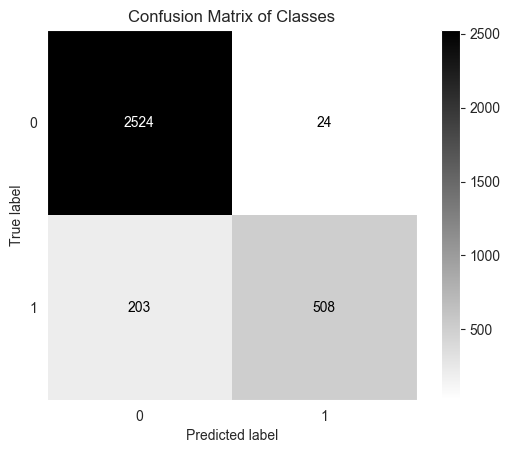


              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2548
           1       0.95      0.71      0.82       711

    accuracy                           0.93      3259
   macro avg       0.94      0.85      0.89      3259
weighted avg       0.93      0.93      0.93      3259



In [110]:
eval_classification(y_test, predict_test, best_xgb)